# Setup

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

import csv
import emoji

# Helper Function
- Read Data

In [2]:
def read_data(filename):
    
    phrase, emoji = [], []
    
    with open(filename) as file:
        f = csv.reader(file)
        for line in f:
            phrase.append(line[0])
            emoji.append(line[1])
    
    X = np.asarray(phrase)
    y = np.asarray(emoji, dtype=int)
    
    return X, y

- Load GloVe word embeddings

In [3]:
def read_glove_vecs(glove_file):
    
    with open(glove_file, 'r') as f:
        words = set()
        word_to_vec_map = {}
        for line in f:
            line = line.strip().split()
            curr_word = line[0]
            words.add(curr_word)
            word_to_vec_map[curr_word] = np.array(line[1:], dtype=np.float64)
        
        i = 1
        word_to_index = {}
        index_to_word = {}
        for w in sorted(words):
            word_to_index[w] = i
            index_to_word[i] = w
            i += 1
    
    return word_to_index, index_to_word, word_to_vec_map

- Softmax

In [4]:
def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / np.sum(e_x)

- One-hot Encoder

In [5]:
def one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)]
    return Y

- Label-to-Emoji

In [6]:
emoji_dictionary = {"0": "\u2764\uFE0F",    # :heart: prints a black instead of red heart depending on the font
                    "1": ":baseball:",
                    "2": ":smile:",
                    "3": ":disappointed:",
                    "4": ":fork_and_knife:"}

def label_to_emoji(label):
    return emoji.emojize(emoji_dictionary[str(label)], use_aliases=True)

- Print Predictions

In [7]:
def print_predictions(X, y_pred):
    print()
    for i in range(X.shape[0]):
        print(X[i], label_to_emoji(int(pred[i])))

- Plot Confusion Matrix

In [8]:
def plot_confusion_matrix(y, y_pred, cmap=plt.cm.gray_r):
    
    df_confusion = pd.crosstab(y, y_pred.reshape(y_pred.shape[0],), rownames=['Actual'], colnames=['Predicted'], margins=True)
    
    plt.matshow(df_confusion, cmap=cmap)  # imshow
    plt.colorbar()
    tick_marks = np.arange(len(df_confusion.columns))
    plt.xticks(ticks=tick_marks, labels=df_confusion.columns, rotation=45)
    plt.yticks(ticks=tick_marks, labels=df_confusion.index)
    plt.xlabel(df_confusion.columns.name)
    plt.ylabel(df_confusion.index.name)

- Prediction

In [9]:
def predict(X, y, W, b, word_to_vec_map):
    '''
    Given X (sentences) and y (emoji indices), predict emojis and compute the accuracy of the model over given set
    
    Returns:
    y_pred: numpy array of shape (m, 1) with the predictions
    '''
    
    # Initialization
    m = X.shape[0]
    y_pred = np.zeros((m, 1))
    
    # Loop over the test set
    for j in range(m):
        
        ## split the jth test sentence into list of lower case words
        words = X[j].lower().split()
        
        ## average words vectors
        avg = sum(word_to_vec_map[word] for word in words) / len(words)
        
        ## forward propagation
        z = np.dot(W, avg) + b
        a = softmax(z)
        y_pred[j] = np.argmax(a)
        
    print('Accuracy: ' + str(np.mean((y_pred == y.reshape(-1, 1)))))
    
    return y_pred

# Baseline Model
## Dataset
- X: sentences
- Y: integer label between 0 and 4 corresponding to an emoji for each sentence

In [10]:
# 127 training instances
X_train, y_train = read_data('./train_emoji.csv')

# 56 test instances
X_test, y_test = read_data('./tesss.csv')

Overview

In [11]:
for idx in range(10):
    print(X_train[idx], label_to_emoji(y_train[idx]))

never talk to me again 😞
I am proud of your achievements 😄
It is the worst day in my life 😞
Miss you so much ❤️
food is life 🍴
I love you mum ❤️
Stop saying bullshit 😞
congratulations on your acceptance 😄
The assignment is too long  😞
I want to go play ⚾


## Model: Emojiffier-V1
* Inputs: a string corresponding to a sentence
* Outputs: a probability vector of shape (1,5) (there are 5 emojis to choose from)
* Architecture: 
    1. average the word vectors for the sentence string
    2. pass the avg vector to softmax layer and return a probability vector
    3. extract the index with the highest probability by argmax layer
* Drawback: just average all word's embeddings, without considering the **ordering** or **combinations** of words

**Load GloVe word embeddings**

In [12]:
word_to_index, index_to_word, word_to_vec_map = read_glove_vecs('./glove.6B.50d.txt')

**Average word vectors for sentence**

In [13]:
def sentence_to_avg(sentence, word_to_vec_map):
    '''
    Convert a sentence (string) into a list of words, extract the GloVe vectors of each word and average the values into a single vector.
    
    Arguments:
        --sentence: string, input sentence
    
    Returns:
    avg: average vector
    '''
    
    # Split the sentence into a list of lower case words
    words = sentence.lower().split()
    
    # Average the GloVe vectors for all words
    avg = sum(word_to_vec_map[word] for word in words) / len(words)
    
    return avg

- Model
$$ z^{(i)} = W . avg^{(i)} + b$$

$$ a^{(i)} = softmax(z^{(i)})$$

$$ \mathcal{L}^{(i)} = - \sum_{k = 0}^{n_y - 1} Y_{oh,k}^{(i)} * log(a^{(i)}_k)$$

In [14]:
def Emojify_V1(X, y, word_to_vec_map, lr=0.01, epochs=400):
    
    # Setup
    np.random.seed(1)
    m = X.shape[0]
    n_y = 5
    n_h = word_to_vec_map['a'].shape[0]
    
    # Initialize parameters using Xavier initialization
    W = np.random.randn(n_y, n_h) / np.sqrt(n_h)
    b = np.zeros((n_y,))
    
    # Convert y into ont-hot format, suitable for softmax classifier: from (m, 1) to (m, n_y)
    y_1h = one_hot(y, C=n_y)
    
    # Optimization loop
    for t in range(epochs):
        for i in range(m):
            
            ## average the word vectors for ith training instance
            avg = sentence_to_avg(X[i], word_to_vec_map)
            
            # forward propagation
            z = np.dot(W, avg) + b
            a = softmax(z)
            
            # cost function
            cost = - np.sum(y_1h[i] * np.log(a))
            
            # compute gradients
            dz = a - y_1h[i]
            dW = np.dot(dz.reshape(n_y, 1), avg.reshape(1, n_h))
            db = dz
            
            # update parameters with SGD
            W -= lr * dW
            b -= lr * db
        
        if t % 100 == 0:
            print('Epoch: ' + str(t) + ' --- cost = ' + str(cost))
            y_pred = predict(X, y, W, b, word_to_vec_map)
    
    return y_pred, W, b

- Experiment

In [15]:
pred, W, b = Emojify_V1(X_train, y_train, word_to_vec_map)
print(pred)

Epoch: 0 --- cost = 1.9520498812810076
Accuracy: 0.3484848484848485
Epoch: 100 --- cost = 0.07971818726014794
Accuracy: 0.9318181818181818
Epoch: 200 --- cost = 0.04456369243681402
Accuracy: 0.9545454545454546
Epoch: 300 --- cost = 0.03432267378786059
Accuracy: 0.9696969696969697
[[3.]
 [2.]
 [3.]
 [0.]
 [4.]
 [0.]
 [3.]
 [2.]
 [3.]
 [1.]
 [3.]
 [3.]
 [1.]
 [3.]
 [2.]
 [3.]
 [2.]
 [3.]
 [1.]
 [2.]
 [3.]
 [0.]
 [2.]
 [2.]
 [2.]
 [1.]
 [4.]
 [3.]
 [3.]
 [4.]
 [0.]
 [3.]
 [4.]
 [2.]
 [0.]
 [3.]
 [2.]
 [2.]
 [3.]
 [4.]
 [2.]
 [2.]
 [0.]
 [2.]
 [3.]
 [0.]
 [3.]
 [2.]
 [4.]
 [3.]
 [0.]
 [3.]
 [3.]
 [3.]
 [4.]
 [2.]
 [1.]
 [1.]
 [1.]
 [2.]
 [3.]
 [1.]
 [0.]
 [0.]
 [0.]
 [3.]
 [4.]
 [4.]
 [2.]
 [2.]
 [1.]
 [2.]
 [0.]
 [3.]
 [2.]
 [2.]
 [0.]
 [3.]
 [3.]
 [1.]
 [2.]
 [1.]
 [2.]
 [2.]
 [4.]
 [3.]
 [3.]
 [2.]
 [4.]
 [0.]
 [0.]
 [3.]
 [3.]
 [3.]
 [3.]
 [2.]
 [0.]
 [1.]
 [2.]
 [3.]
 [0.]
 [2.]
 [2.]
 [2.]
 [3.]
 [2.]
 [2.]
 [2.]
 [4.]
 [1.]
 [1.]
 [3.]
 [3.]
 [4.]
 [1.]
 [2.]
 [1.]
 [1.]
 [3.]
 [1.]

- Evaluation

In [16]:
print("Training set:")
y_train_pred = predict(X_train, y_train, W, b, word_to_vec_map)
print('Test set:')
y_test_pred = predict(X_test, y_test, W, b, word_to_vec_map)

Training set:
Accuracy: 0.9772727272727273
Test set:
Accuracy: 0.8571428571428571


- Confusion Matrix

(56,)
           ❤️    ⚾    😄    😞   🍴
Predicted  0.0  1.0  2.0  3.0  4.0  All
Actual                                 
0            6    0    0    1    0    7
1            0    8    0    0    0    8
2            2    0   16    0    0   18
3            1    1    2   12    0   16
4            0    0    1    0    6    7
All          9    9   19   13    6   56


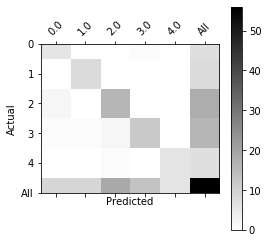

In [17]:
print(y_test.shape)
print('           '+ label_to_emoji(0)+ '    ' + label_to_emoji(1) + '    ' +  label_to_emoji(2)+ '    ' + label_to_emoji(3)+'   ' + label_to_emoji(4))
print(pd.crosstab(y_test, y_test_pred.reshape(56,), rownames=['Actual'], colnames=['Predicted'], margins=True))
plot_confusion_matrix(y_test, y_test_pred)

# LSTM Model
## Padding
* Train Keras using mini-batches, but sequences have different length
* Common solution: use **Padding** handle sequences of varying length
    1. set a maximum sequence length
    2. pad all sequences to have the same length with "0"s

## Embedding Layer
* In Keras, the embedding matrix is represented as a "layer"
* The embedding matrix maps word indices to embedding vectors
    - the word indices are positive integers; the embedding vectors are dense vectors of fixed size
    - "dense": most of the values are non-zero; counter-example: one-hot encoded vector
* Use and update the pre-trained embeddings
    - create an [Embedding()](https://keras.io/layers/embeddings/) layer in Keras
    - initialize the Embedding layer with the GloVe 50-dimensional vectors
    - in Keras, it allows you to either train or leave fixed this layer; in our case, the training set is quite small, we will leave the GloVe embeddings fixed instead of updating them

* Inputs and outputs to the embedding layer
    * The input is an integer matrix of size **(batch size, max input length)**:
        - the "max input length" is achieved by zero-padded
        - the sentences are converted into lists of indices (integers)
        * the largest integer (the highest word index) should be no larger than the vocabulary size
    * The output is an array of shape **(batch size, max input length, dimension of word vectors)**

**Prepare the input sentences**

In [18]:
def sentences_to_indices(X, word_to_index, max_len):
    '''
    Convert an array of sentences (strings) into an array of indices corresponding to words in the sentences
    
    Arguments:
        --X: input array of sentences (strings), of shape (m, 1)
        --max_len: maximum number of words in a sentence ~ zero-padding
    
    Return:
    X_indices: array of indices corresponding to words in the sentences from X, of shape (m, max_len)
    '''
    
    # Initialization
    m = X.shape[0]
    X_indices = np.zeros((m, max_len))
    
    # Loop over the whole training instances
    for i in range(m):
        
        ## split the ith training sentence into lower case word list
        words = X[i].lower().split()
        
        ## initialize j to 0
        j = 0
        
        ## loop over the words in the ith training sentence
        for word in words:
            X_indices[i, j] = word_to_index[word]
            j += 1
    
    return X_indices

**Build embedding layer**
- Embedding matrix is a numpy array of shape **(vocabulary length, embedding dimension)**
    - vocabulary length = number of unique words + 1 (for "unkonw" words)
    - for GloVe word embeddings, the dimension = 50
- With [Embedding()](https://keras.io/layers/embeddings/) layer in Keras
    - make the layer's embeddings fixed: in our case, we don't want the model to modify the word embeddings
    - set `trainable = False`
    - set the embedding weights to be equal to the embedding matrix

In [19]:
def pretrained_embedding_layer(word_to_vec_map, word_to_index):
    '''
    Create a Keras Embedding() layer and loads in pre-trained GloVe 50-dimensional vectors
    
    Returns:
    embedding_layer: pretrained layer Keras instance
    '''
    
    # Initialization
    vocab_len = len(word_to_index) + 1
    emb_dim = word_to_vec_map['a'].shape[0]
    emb_matrix = np.zeros((vocab_len, emb_dim))
    
    # Fill in the embedding matrix with the GloVe vector
    for word, idx in word_to_index.items():
        emb_matrix[idx, :] = word_to_vec_map[word]
    
    # Define Keras Embedding layer
    embedding_layer = tf.keras.layers.Embedding(input_dim=vocab_len, output_dim=emb_dim, trainable=False)
    
    # Build the embedding layer; this is required before setting the weights of the embedding layer
    embedding_layer.build((None,))
    
    # Set the weights of the embedding layer to the embedding matrix ~ pre-trained
    embedding_layer.set_weights([emb_matrix])
    
    return embedding_layer

## Model: Emojifier-V2
* Modeling with LSTM, taking word sequences as input $\to$ capture word ordering or combination
* Will continue to use pre-trained word embedings to represent words
* Network Architecture:
    1. **2-layer LSTM** sequence model
    2. feed embedding vector of each word to the **LSTM** cell as each time-step input
    3. use **Dropout layer** to regularize the 1st layer output and feed to the 2nd layer as the input to **LSTM**
    4. in the end, use a **Dropout layer + Softmax layer** to output the probability vector for the emoji classification

In [20]:
def Emojify_V2(input_shape, word_to_vec_map, word_to_index):
    '''
    Create the Emojify-V2 model' graph
    
    Arguments:
        --input_shape: shape of the input, usually (max_len,)
    
    Returns:
    model -- a model instance in Keras
    '''
    
    # Input layer: define input of the graph
    sentence_indices = tf.keras.layers.Input(shape=input_shape, dtype='int32')
    
    # Embedding layer: pre-trained with GloVe vectors
    embedding_layer = pretrained_embedding_layer(word_to_vec_map, word_to_index)
    
    # Preprocess for embeddings
    embeddings = embedding_layer(sentence_indices)
    
    # Feed embeddings to the 1st LSTM layer with 128-dimensional hidden state; the output should be a batch of sequences
    X = tf.keras.layers.LSTM(units=128, return_sequences=True)(embeddings)
    
    # Add Dropout layer with rate of 0.5
    X = tf.keras.layers.Dropout(rate=0.5)(X)
    
    # Feed the output to the 2nd LSTM layer with 128-dimensional hidden state; the output should be a single hidden state (last one)
    X = tf.keras.layers.LSTM(units=128, return_sequences=False)(X)
    
    # Add Dropout layer with rate of 0.5
    X = tf.keras.layers.Dropout(rate=0.5)(X)
    
    # Propagate the output through a Dense layer with 5 units + softmax activation function
    X = tf.keras.layers.Dense(units=5, activation='softmax')(X)
    
    # Create Model instance
    model = tf.keras.Model(inputs=sentence_indices, outputs=X)
    
    return model

- Create Model

In [21]:
max_len = 10

model = Emojify_V2((max_len,), word_to_vec_map, word_to_index)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 10)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 10, 50)            20000050  
_________________________________________________________________
lstm (LSTM)                  (None, 10, 128)           91648     
_________________________________________________________________
dropout (Dropout)            (None, 10, 128)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 5)                 645   

- Compile

In [22]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

- Train

In [23]:
X_train_indices = sentences_to_indices(X_train, word_to_index, max_len)
y_train_1h = one_hot(y_train, C=5)

model.fit(X_train_indices, y_train_1h, epochs=50, batch_size=32, shuffle=True)

Train on 132 samples
Epoch 1/50
132/132 [==============================] - 2s 18ms/sample - loss: 1.5699 - accuracy: 0.2500
Epoch 2/50
132/132 [==============================] - 0s 2ms/sample - loss: 1.4931 - accuracy: 0.3106
Epoch 3/50
132/132 [==============================] - 0s 2ms/sample - loss: 1.4530 - accuracy: 0.3561
Epoch 4/50
132/132 [==============================] - 0s 2ms/sample - loss: 1.3960 - accuracy: 0.4015
Epoch 5/50
132/132 [==============================] - 0s 2ms/sample - loss: 1.2483 - accuracy: 0.5909
Epoch 6/50
132/132 [==============================] - 0s 2ms/sample - loss: 1.1495 - accuracy: 0.5379
Epoch 7/50
132/132 [==============================] - 0s 2ms/sample - loss: 1.0454 - accuracy: 0.6136
Epoch 8/50
132/132 [==============================] - 0s 2ms/sample - loss: 0.8815 - accuracy: 0.6667
Epoch 9/50
132/132 [==============================] - 0s 2ms/sample - loss: 0.7683 - accuracy: 0.7424
Epoch 10/50
132/132 [==============================] - 0s 2m

- Evaluation

In [24]:
X_test_indices = sentences_to_indices(X_test, word_to_index, max_len)
y_test_1h = one_hot(y_test, C = 5)
loss, acc = model.evaluate(X_test_indices, y_test_1h)
print()
print("Test accuracy = ", acc)

56/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================